Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('athletes.csv')
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
print('Смотрим пропуск в дате рождения', end='\n\n')
print(df[df['dob'].isna()], end='\n\n')
print('------------------------------------------------------------------')
print('Смотрим пропуск в росте', end='\n\n')
print(df[df['height'].isna()], end='\n\n')
print('------------------------------------------------------------------')
print('Смотрим пропуск в весе', end='\n\n')
print(df[df['weight'].isna()], end='\n\n')
print('------------------------------------------------------------------')

Смотрим пропуск в дате рождения

             id           name nationality   sex  dob  height  weight  \
8546  663676373  Pavel Sozykin         RUS  male  NaN     NaN     NaN   

        sport  gold  silver  bronze  
8546  sailing     0       0       0  

------------------------------------------------------------------
Смотрим пропуск в росте

              id                  name nationality     sex       dob  height  \
12     258556239            Abbas Qali         IOA    male  10/11/92     NaN   
47     469953606    Abdoullah Bamoussa         ITA    male    6/8/86     NaN   
50     325809293            Abdul Omar         GHA    male   10/3/93     NaN   
52     262868423    Abdulaziz Alshatti         IOA    male  10/30/90     NaN   
56     897549624     Abdullah Hel Baki         BAN    male    8/1/89     NaN   
...          ...                   ...         ...     ...       ...     ...   
11031  404382792          Winston Hill         FIJ    male   9/17/93     NaN   
11208  5506

Видим, что есть один пропуск в дате рождения, 330 пропусков в росте и 659 в весе.

Пропуск  в дате рождения я пропущу т.к. не буду использовать это как признак спортсмена для предсказания его пола + всего один пропуск, а рост и вес попробую заполнить среднеарифметическим по группе.

In [ ]:
# Попробую заменить рост и вес по полу, национальности и принадлежности к спорту
df['height'] = df['height'].fillna(df.groupby(['sex', 'nationality', 'sport'])['height'].transform('mean'))
df['weight'] = df['weight'].fillna(df.groupby(['sex', 'nationality', 'sport'])['weight'].transform('mean'))

In [ ]:
df.info()
# Видимо, что не все пропуски заполнились, попробуем более простую группировку без национальности

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11353 non-null  float64
 6   weight       11061 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
df['height'] = df['height'].fillna(df.groupby(['sex', 'sport'])['height'].transform('mean'))
df['weight'] = df['weight'].fillna(df.groupby(['sex', 'sport'])['weight'].transform('mean'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11538 non-null  float64
 6   weight       11252 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
# Видимо, что не все пропуски заполнились, попробуем еще более простую группировку только по полу
df['height'] = df['height'].fillna(df.groupby(['sex'])['height'].transform('mean'))
df['weight'] = df['weight'].fillna(df.groupby(['sex'])['weight'].transform('mean'))

In [ ]:
df.info()
# Наши пропуски заполнены, кроме одного в дате рождения, но я не буду использовать ДОБ в качестве признака для обучения и удалю этот столбец

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11538 non-null  float64
 6   weight       11538 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
df.drop('dob', inplace=True, axis=1)
df.head()

,id,name,nationality,sex,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,1.81,71.0,cycling,0,0,0


Далее выделим признаки для обучения и преобразуем национальности и спорта как dummies кодирование, а пол как label encoding

In [ ]:
features = df[['nationality', 'height', 'weight', 'sport', 'gold', 'silver', 'bronze']]
features.head()

,nationality,height,weight,sport,gold,silver,bronze
0,ESP,1.72,64.0,athletics,0,0,0
1,KOR,1.68,56.0,fencing,0,0,0
2,CAN,1.98,79.0,athletics,0,0,1
3,MDA,1.83,80.0,taekwondo,0,0,0
4,NZL,1.81,71.0,cycling,0,0,0


In [ ]:
X = pd.get_dummies(features, columns=['nationality', 'sport'])
X.head()

,height,weight,gold,silver,bronze,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
le = LabelEncoder()

In [ ]:
target = pd.Series(le.fit_transform(df['sex']))
target

0        1
1        0
2        1
3        1
4        1
        ..
11533    0
11534    0
11535    1
11536    1
11537    1
Length: 11538, dtype: int64

Стандартизуем данные и сделаем пайплайн обучения логистической регрессии

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000)
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [ ]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
lr_model.score(X_train, y_train)

0.8489707475622968

In [ ]:
lr_model.score(X_test, y_test)

0.8396880415944541

Оценка качества модели

In [ ]:
predictions = lr_model.predict_proba(X_test)

In [ ]:
tp = 0
fp = 0
fn = 0
tn = 0

for pred_prob, actual in zip(predictions[:,1], y_test):
  if pred_prob >= 0.5:
    predicted = 1
  else:
    predicted = 0

  if predicted == 1:
    if actual == 1:
      tp += 1
    else:
      fp += 1
  else:
    if actual == 1:
      fn += 1
    else:
      tn += 1

In [ ]:
tp, fp, fn, tn

(1067, 166, 204, 871)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 871,  166],
       [ 204, 1067]])

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy
# Получаем такой же результат как в lr_model.score

0.8396880415944541

In [ ]:
precision = tp / (tp + fp)
precision

0.8653690186536902

In [ ]:
precision_score(y_test, y_pred)
# Сравниваем precision

0.8653690186536902

In [ ]:
recall = tp / (tp + fn)
recall

0.8394964594807238

In [ ]:
recall_score(y_test, y_pred)
# Сравниваем recall

0.8394964594807238

Строим ROC-кривую и вычисляем значение ROC-AUC метрики.

In [ ]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

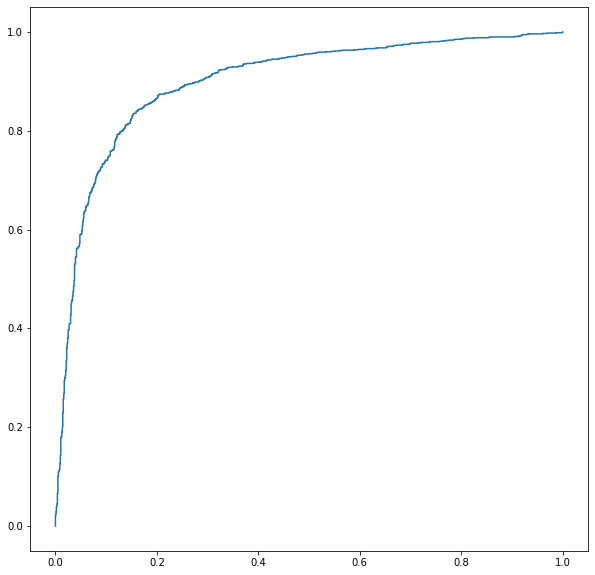

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)

In [ ]:
predictions[:,1]

array([0.99731046, 0.32894535, 0.89826802, ..., 0.73870863, 0.16607464,
       0.95287018])

In [ ]:
roc_auc_score(y_test, predictions[:, 1])

0.8990126909388048

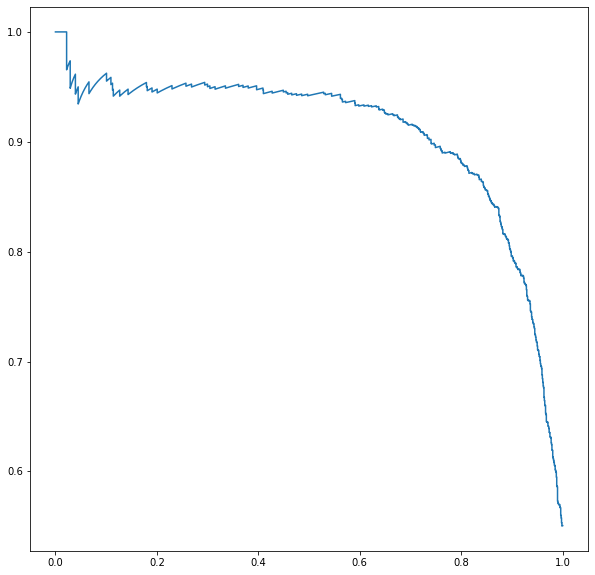

In [ ]:
pr, re, thres = precision_recall_curve(y_test, predictions[:, 1])
plt.figure(figsize=(10,10))
plt.plot(re, pr)

FPR and TPR

In [ ]:
fpr_ = []
tpr_ = []

pr_ = []
re_ = []

for step in np.arange(0,1, 0.00001):

  tp = 0
  fp = 0
  fn = 0
  tn = 0

  for pred_prob, actual in zip(predictions[:,1], y_test):
    if pred_prob > step:
      predicted = 1
    else:
      predicted = 0

    if predicted == 1:
      if actual == 1:
        tp += 1
      else:
        fp += 1
    else:
      if actual == 1:
        fn += 1
      else:
        tn += 1

  fpr_.append(fp / (fp + tn))
  tpr_.append(tp / (tp + fn))

  if tp !=0 and fp !=0:
    pr_.append(tp / (tp + fp))
    re_.append(tp / (tp + fn))

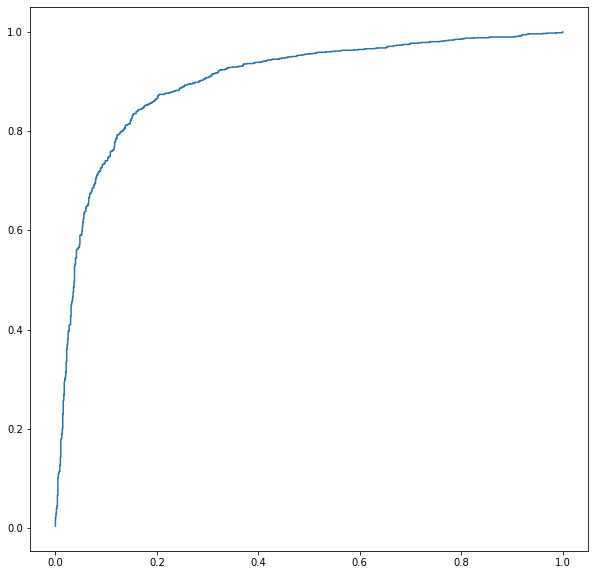

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(fpr_, tpr_)

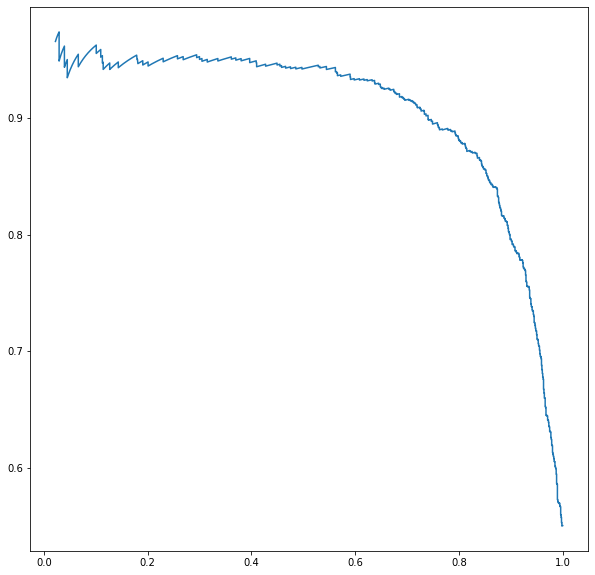

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(re_, pr_)